<a href="https://colab.research.google.com/github/joaomottin/DataScienceLab/blob/main/GraficoAmazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
from google.colab import files
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

uploaded = files.upload()


Saving amazon_cells_labelled.txt to amazon_cells_labelled (3).txt


In [106]:
df = pd.read_csv(io.BytesIO(uploaded['amazon_cells_labelled (3).txt']),sep = '\t')
print(df)

                                                  text  target
0    So there is no way for me to plug it in here i...       0
1                          Good case, Excellent value.       1
2                               Great for the jawbone.       1
3    Tied to charger for conversations lasting more...       0
4                                    The mic is great.       1
..                                                 ...     ...
995  The screen does get smudged easily because it ...       0
996  What a piece of junk.. I lose more calls on th...       0
997                       Item Does Not Match Picture.       0
998  The only thing that disappoint me is the infra...       0
999  You can not answer calls with the unit, never ...       0

[1000 rows x 2 columns]


In [107]:
#Mostra a quantidade de linhas e colunas
df.shape

(1000, 2)

In [108]:
df.groupby('target')['target'].count()

,target
target,
0,500
1,500


In [109]:
print("\nVerificando balanceamento:")
contagem_classes = df.groupby('target')['target'].count()
total = contagem_classes.sum()
porcentagem_classes = contagem_classes / total * 100
print(porcentagem_classes)


# Separamos os dados para treino e test
from sklearn.model_selection import train_test_split
X = df['text']
y = df['target']

#Embaralhamos os dados sendo 25% para teste e 75% para treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"\nTamanho do Treino: {len(X_train)} amostras")
print(f"Tamanho do Teste: {len(X_test)} amostras")


Verificando balanceamento:
target
0    50.0
1    50.0
Name: target, dtype: float64

Tamanho do Treino: 750 amostras
Tamanho do Teste: 250 amostras


In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Baixa uma lista de palavras que não tem peso para frases (stopwords)
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Inicializa o vetorizador
vectorizer = TfidfVectorizer(stop_words=stop_words)

# Aprende o vocabulário e transforma os dados de TREINO
X_train_tfidf = vectorizer.fit_transform(X_train)

# Apenas transforma os dados de TESTE (usando o vocabulário do treino)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\nShape da matriz TF-IDF (Treino): {X_train_tfidf.shape}")


Shape da matriz TF-IDF (Treino): (750, 1455)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [111]:
# --- 4. OTIMIZAÇÃO DE HIPERPARÂMETROS (Grid Search) (Item v) ---

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

print("\n--- Iniciando Otimização (Grid Search) ---")

# --- 4.1 Otimização para RandomForest ---
print("Iniciando Grid Search para RandomForest...")

# Define os parâmetros que queremos testar
param_grid_rf = {
    'n_estimators': [100, 200],         # Número de árvores
    'max_depth': [None, 30],            # Profundidade máxima
    'min_samples_leaf': [1, 2]          # Mínimo de amostras por folha
}

# Cria o objeto GridSearchCV
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              cv=3, # 3-fold cross-validation (mais rápido)
                              n_jobs=-1, # Usar todos os processadores
                              scoring='f1') # Otimizar pelo F1-score

# Executa a busca nos dados de treino
grid_search_rf.fit(X_train_tfidf, y_train)

# Pega o MELHOR modelo de RandomForest encontrado
model = grid_search_rf.best_estimator_

print(f"Melhores parâmetros para RandomForest: {grid_search_rf.best_params_}")
print(f"Melhor F1-score (validação): {grid_search_rf.best_score_:.4f}")


# --- 4.2 Otimização para Regressão Logística ---
print("\nIniciando Grid Search para Regressão Logística...")

# Define os parâmetros para testar
param_grid_lr = {
    'C': [0.1, 1.0, 10.0],           # Força da regularização
    'solver': ['liblinear', 'saga'],  # Algoritmos de otimização
    'penalty': ['l1', 'l2']           # Tipo de regularização
}

# Cria o objeto GridSearchCV
grid_search_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42),
                              param_grid=param_grid_lr,
                              cv=3,
                              n_jobs=-1,
                              scoring='f1')

# Executa a busca nos dados de treino
grid_search_lr.fit(X_train_tfidf, y_train)

# Pega o MELHOR modelo de Regressão Logística encontrado
lr_model = grid_search_lr.best_estimator_

print(f"Melhores parâmetros para Regressão Logística: {grid_search_lr.best_params_}")
print(f"Melhor F1-score (validação): {grid_search_lr.best_score_:.4f}")


--- Iniciando Otimização (Grid Search) ---
Iniciando Grid Search para RandomForest...
Melhores parâmetros para RandomForest: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
Melhor F1-score (validação): 0.7429

Iniciando Grid Search para Regressão Logística...
Melhores parâmetros para Regressão Logística: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor F1-score (validação): 0.7807


In [112]:
# --- 5. AVALIAÇÃO DOS MODELOS OTIMIZADOS (Item vi) ---

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve)

print("\n--- Avaliação de Performance dos Modelos Otimizados ---")

# --- 5.1 Previsões (com os modelos otimizados) ---

# RandomForest
y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] # Probabilidades de ser positivo (classe 1)

# Regressão Logística
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1] # Probabilidades de ser positivo

# --- 5.2 Cálculo das Métricas ---

# Métricas para o RandomForest
print("\nRandom Forest (Otimizado):")
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_auc_roc = roc_auc_score(y_test, y_pred_proba)
rf_auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"Acurácia: {rf_accuracy:.4f}")
print(f"Precisão: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"AUC-ROC: {rf_auc_roc:.4f}")
print(f"AUC-PR (AP): {rf_auc_pr:.4f}")

# Métricas para a Regressão Logística
print("\nRegressão Logística (Otimizada):")
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc_roc = roc_auc_score(y_test, y_pred_proba_lr)
lr_auc_pr = average_precision_score(y_test, y_pred_proba_lr)

print(f"Acurácia: {lr_accuracy:.4f}")
print(f"Precisão: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"AUC-ROC: {lr_auc_roc:.4f}")
print(f"AUC-PR (AP): {lr_auc_pr:.4f}")


--- Avaliação de Performance dos Modelos Otimizados ---

Random Forest (Otimizado):
Acurácia: 0.7400
Precisão: 0.7623
Recall: 0.7209
F1-Score: 0.7410
AUC-ROC: 0.8396
AUC-PR (AP): 0.8536

Regressão Logística (Otimizada):
Acurácia: 0.7920
Precisão: 0.7984
Recall: 0.7984
F1-Score: 0.7984
AUC-ROC: 0.9052
AUC-PR (AP): 0.8907



Plotando curvas de avaliação com pontos de corte ótimos...

Random Forest - Ponto de Corte Ótimo (ROC): 0.6558
  -> Com este corte: TPR=0.6434, FPR=0.1074

Regressão Logística - Ponto de Corte Ótimo (ROC): 0.6718
  -> Com este corte: TPR=0.7442, FPR=0.0496


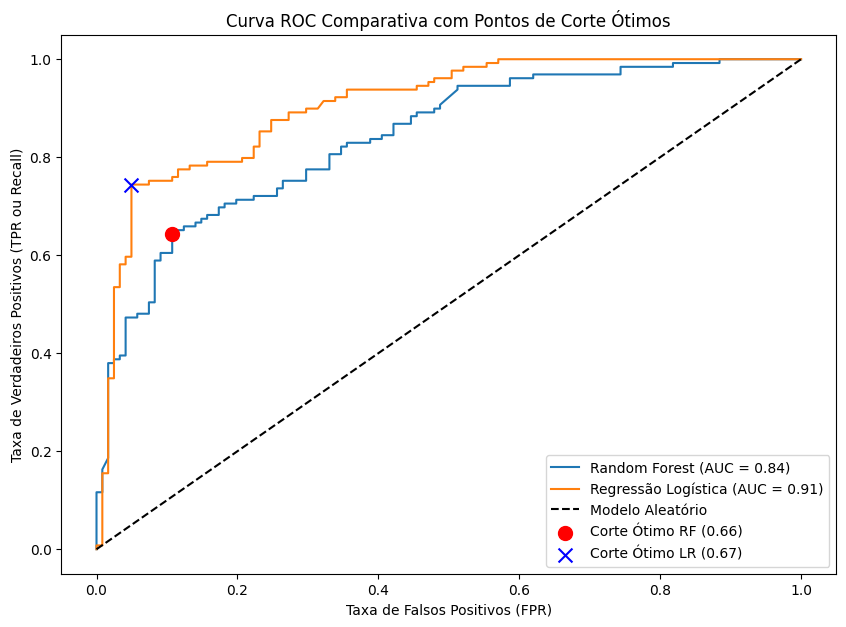

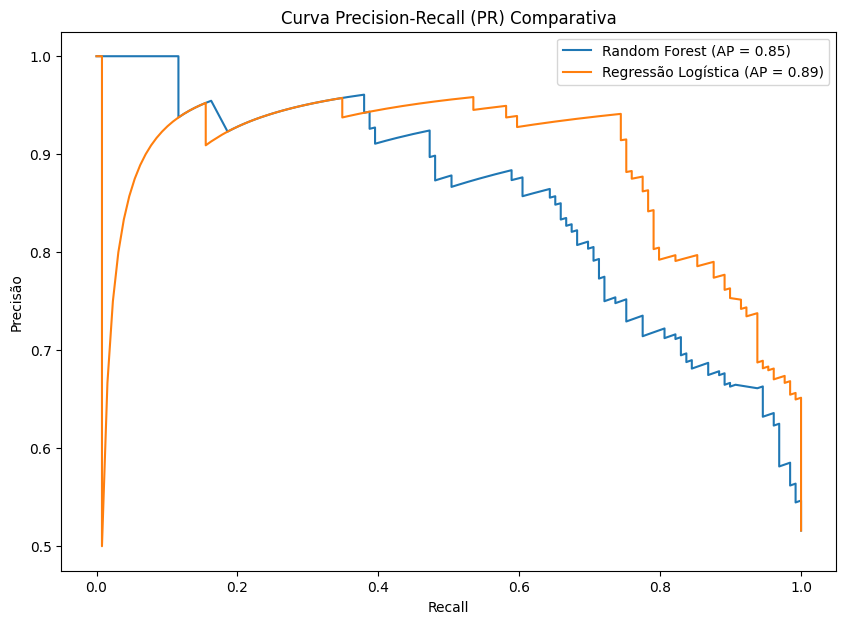

In [113]:
# --- 5.3 Plotar Curvas ROC e PR (COM PONTO DE CORTE ÓTIMO) ---

print("\nPlotando curvas de avaliação com pontos de corte ótimos...")

# --- Curva ROC ---

# 1. Calcular dados para RandomForest (agora salvando os 'thresholds_rf')
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba)

# 2. Encontrar o ponto de corte ótimo para RF
#    (Calcula o ponto com a maior diferença entre TPR e FPR - Índice Youden)
optimal_idx_rf = np.argmax(tpr_rf - fpr_rf)
optimal_threshold_rf = thresholds_rf[optimal_idx_rf]
optimal_fpr_rf = fpr_rf[optimal_idx_rf]
optimal_tpr_rf = tpr_rf[optimal_idx_rf]

print(f"\nRandom Forest - Ponto de Corte Ótimo (ROC): {optimal_threshold_rf:.4f}")
print(f"  -> Com este corte: TPR={optimal_tpr_rf:.4f}, FPR={optimal_fpr_rf:.4f}")


# 3. Calcular dados para Regressão Logística (salvando 'thresholds_lr')
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)

# 4. Encontrar o ponto de corte ótimo para LR
optimal_idx_lr = np.argmax(tpr_lr - fpr_lr)
optimal_threshold_lr = thresholds_lr[optimal_idx_lr]
optimal_fpr_lr = fpr_lr[optimal_idx_lr]
optimal_tpr_lr = tpr_lr[optimal_idx_lr]

print(f"\nRegressão Logística - Ponto de Corte Ótimo (ROC): {optimal_threshold_lr:.4f}")
print(f"  -> Com este corte: TPR={optimal_tpr_lr:.4f}, FPR={optimal_fpr_lr:.4f}")


# 5. Plotar o gráfico ROC com os pontos
plt.figure(figsize=(10, 7))
# Plot das curvas
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc_roc:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {lr_auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatório') # Linha de referência

# *** NOVO: Plotar os pontos de corte ótimos ***
plt.scatter(optimal_fpr_rf, optimal_tpr_rf, marker='o', color='red', s=100, zorder=5,
            label=f'Corte Ótimo RF ({optimal_threshold_rf:.2f})')
plt.scatter(optimal_fpr_lr, optimal_tpr_lr, marker='x', color='blue', s=100, zorder=5,
            label=f'Corte Ótimo LR ({optimal_threshold_lr:.2f})')

plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.title('Curva ROC Comparativa com Pontos de Corte Ótimos')
plt.legend()
plt.show()


# --- Curva PR (Precision-Recall) ---
# (Este código continua o mesmo de antes, mas está incluído para facilitar a cópia)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(10, 7))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {rf_auc_pr:.2f})')
plt.plot(recall_lr, precision_lr, label=f'Regressão Logística (AP = {lr_auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall (PR) Comparativa')
plt.legend()
plt.show()


--- Análise de Pontos de Corte (Usando RandomForest) ---


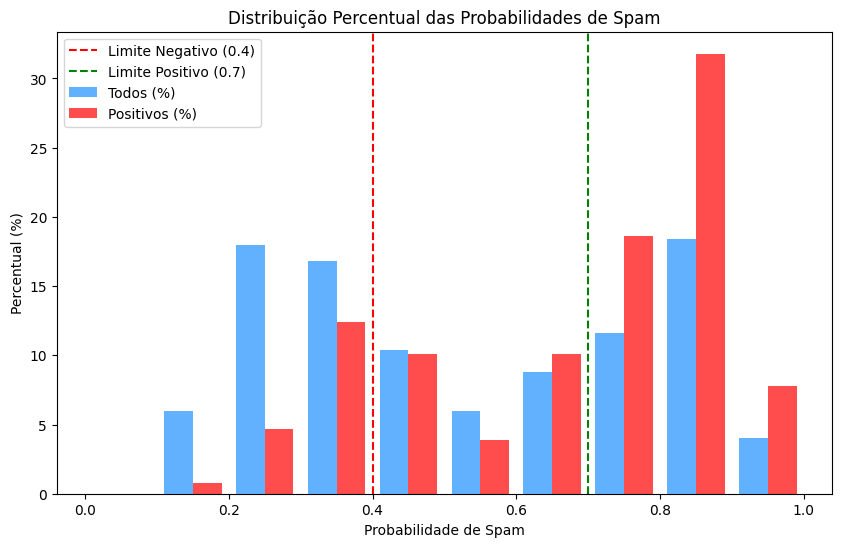

Avaliando métricas para os cortes 0.4 e 0.7...

Corte 0.4
Accuracy: 0.74
Precision: 0.7162162162162162
Recall: 0.8217054263565892
F1: 0.7653429602888087

Corte 0.7
Accuracy: 0.744
Precision: 0.8823529411764706
Recall: 0.5813953488372093
F1: 0.7009345794392523

Divisão por Zonas (Negativa / Manual / Positiva):
zone
negativa    40.8
positiva    34.0
manual      25.2
Name: proportion, dtype: float64


In [115]:
# --- 6. ANÁLISE DE PONTOS DE CORTE (Item vii) ---
# (Usando o melhor modelo. Vamos assumir que foi o RandomForest 'model')

print("\n--- Análise de Pontos de Corte (Usando RandomForest) ---")

#Pega as probabilidades de ser positivo
positive_probs = y_pred_proba # Já calculamos isso antes

#Organiza todas as probabilidades de ser positivo junto do target (y_test)
df_pos = pd.DataFrame({"prob_spam": positive_probs, "target": y_test.values})

#Separa apenas para os que são positivos
df_apenas_positivo = df_pos.loc[df_pos['target']==1]

#Cria as caixas (bins) de 10% em 10% porcento
step = 0.1
bins = np.arange(0, 1 + step, step)

#Faz a contagem de todas as probabilidades
hist_all, _ = np.histogram(df_pos["prob_spam"], bins=bins)
#Faz a contagem somente das probabilidades que realmente eram positivas
hist_pos, _ = np.histogram(df_apenas_positivo["prob_spam"], bins=bins)

# Convertendo para percentual (%)
# (Adicionado .sum() para evitar divisão por zero se um bin estiver vazio)
hist_all_pct = (hist_all / (hist_all.sum() + 1e-9)) * 100
hist_pos_pct = (hist_pos / (hist_pos.sum() + 1e-9)) * 100

# Posicionamento das barras
width = step * 0.4
x = bins[:-1] + step/2

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, hist_all_pct, width=width, label='Todos (%)', color='#1E90FF', alpha=0.7)
plt.bar(x + width/2, hist_pos_pct, width=width, label='Positivos (%)', color='red', alpha=0.7)

plt.xlabel('Probabilidade de Spam')
plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual das Probabilidades de Spam')

# Pontos de corte customizáveis
threshold_neg = 0.4
threshold_pos = 0.7
plt.axvline(threshold_neg, color='red', linestyle='--', label=f'Limite Negativo ({threshold_neg})')
plt.axvline(threshold_pos, color='green', linestyle='--', label=f'Limite Positivo ({threshold_pos})')

plt.legend()
plt.show()

# --- 6.1 Métricas para os pontos de corte ---
print(f"Avaliando métricas para os cortes {threshold_neg} e {threshold_pos}...")

# Corte 0.2 -> considera como positivo apenas prob > 0.2
y_pred_02 = (df_pos["prob_spam"] > threshold_neg).astype(int)

# Corte 0.4 -> considera como positivo prob >= 0.4
y_pred_04 = (df_pos["prob_spam"] >= threshold_pos).astype(int)

# métricas para corte 0.4
print(f"\nCorte {threshold_neg}")
print("Accuracy:", accuracy_score(df_pos["target"], y_pred_02))
print("Precision:", precision_score(df_pos["target"], y_pred_02))
print("Recall:", recall_score(df_pos["target"], y_pred_02))
print("F1:", f1_score(df_pos["target"], y_pred_02))

# métricas para corte 0.7
print(f"\nCorte {threshold_pos}")
print("Accuracy:", accuracy_score(df_pos["target"], y_pred_04))
print("Precision:", precision_score(df_pos["target"], y_pred_04))
print("Recall:", recall_score(df_pos["target"], y_pred_04))
print("F1:", f1_score(df_pos["target"], y_pred_04))

# --- 6.2 Divisão em Zonas ---
def assign_zone(prob):
    if prob <= threshold_neg:
        return "negativa"
    elif prob >= threshold_pos:
        return "positiva"
    else:
        return "manual"

#Usa a função para cada uma das probabilidades
df_pos["zone"] = df_pos["prob_spam"].apply(assign_zone)

# Ver quantos exemplos vão para cada zona
print("\nDivisão por Zonas (Negativa / Manual / Positiva):")
print(df_pos["zone"].value_counts(normalize=True) * 100)


--- Top 10 Palavras Mais Importantes (RandomForest) ---
        Palavra  Importancia
593       great     0.109953
587        good     0.037201
1408       well     0.036018
1439      works     0.030942
943       phone     0.025402
768        love     0.022245
459   excellent     0.020104
858        nice     0.019484
131        best     0.018972
515       first     0.015441


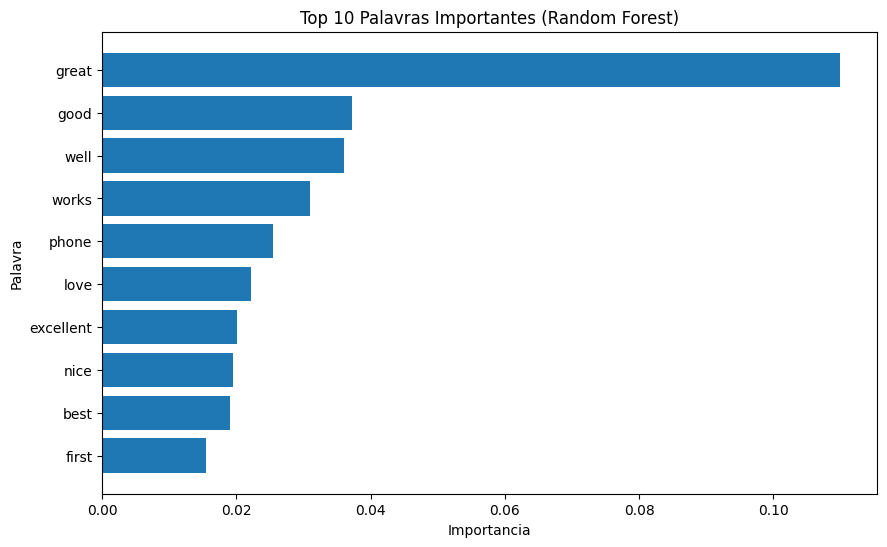

In [116]:
# --- 7. IMPORTÂNCIA DAS FEATURES (PALAVRAS) ---
# (Usando o RandomForest, que tem 'feature_importances_')

print("\n--- Top 10 Palavras Mais Importantes (RandomForest) ---")

#Pega a importancia de cada palavra
importances = model.feature_importances_
#Pega a lista de palavras na mesma ordem
feature_names = vectorizer.get_feature_names_out()

#Cria um dataframe com as palavras e suas notas
feature_importance_df = pd.DataFrame({'Palavra': feature_names, 'Importancia': importances})

#Ordena a tabela pela Importancia
feature_importance_df = feature_importance_df.sort_values('Importancia', ascending=False)

#Quantidade de palavras que queremos
N = 10
print(feature_importance_df.head(N))

#Desenha o gráfico
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Palavra'][:N], feature_importance_df['Importancia'][:N])
plt.xlabel('Importancia')
plt.ylabel('Palavra')
plt.title(f'Top {N} Palavras Importantes (Random Forest)')
plt.gca().invert_yaxis()
plt.show()